
#### Stroke Prediction Dataset
##### 11 clinical features for predicting stroke events

In [28]:
# importing the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
sns.set_theme(style="whitegrid")

In [29]:
# import dataset
df = pd.read_csv("stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [30]:
df["target"] = df.stroke.apply(lambda x: "yes" if x == 1 else "no")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,target
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,yes
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,yes
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,yes
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,yes
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,yes


In [31]:
# check for null values
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
target                 0
dtype: int64

In [32]:
df.shape

(5110, 13)

In [33]:
df.bmi.fillna(df.bmi.mean(), inplace= True)

In [34]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,target
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,yes
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,yes
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,yes
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,yes
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,yes


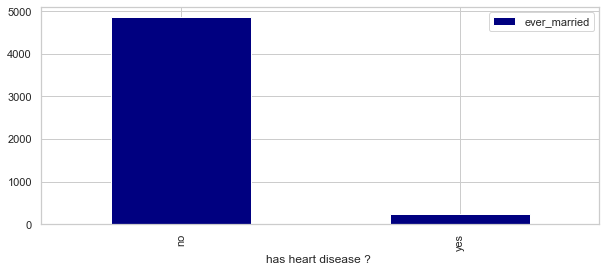

In [35]:
fig, ax =plt.subplots(figsize = (10,4))
df.loc[:,['target','ever_married']].groupby('target').count().plot( kind = 'bar', ax = ax, color = ('navy'))
ax.set(xlabel = 'has heart disease ? ');

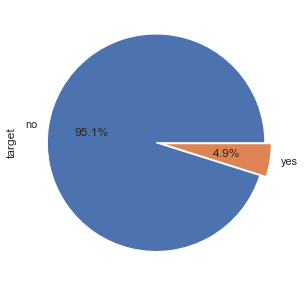

In [36]:
df.target.value_counts().plot(kind= "pie", autopct = "%.1f%%", figsize = (5,5), explode = (0.01,0.05));

In [37]:
df.bmi.mean() , df.bmi.max(), df.bmi.min()

(28.893236911794663, 97.6, 10.3)

<AxesSubplot:>

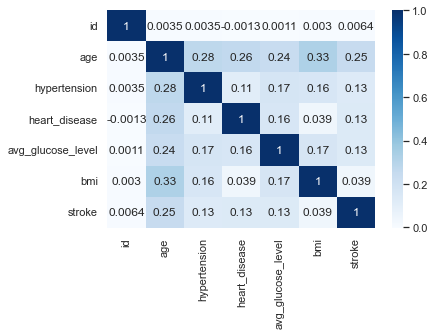

In [38]:
# feature correlation
sns.heatmap(df.corr(), cmap = "Blues", annot = True)

In [12]:
# splitting the dataset into X an y
X = df.drop(["id","stroke","target"], axis =1)
y = df.target
X.shape, y.shape

((5110, 10), (5110,))

## Preprocessing , change strings to numeric with OneHotEncoder

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

features = ['gender','ever_married','work_type','Residence_type','smoking_status']

transformer = make_column_transformer (
                    (OneHotEncoder(handle_unknown ='ignore'),features),
                    remainder='passthrough')

transformedX = transformer.fit_transform(X)
pd.DataFrame(transformedX).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,67.0,0.0,1.0,228.69,36.600000
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,61.0,0.0,0.0,202.21,28.893237
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,80.0,0.0,1.0,105.92,32.500000
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,49.0,0.0,0.0,171.23,34.400000
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,79.0,1.0,0.0,174.12,24.000000


In [14]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(transformedX, y)

In [15]:
from sklearn.model_selection import train_test_split , cross_val_score
X_train,X_test ,y_train ,y_test = train_test_split(X_res,y_res, test_size = 0.2, random_state = 0)  
X_train.shape ,X_test.shape  ,y_train.shape ,y_test.shape

((7777, 21), (1945, 21), (7777,), (1945,))

# Import needed estimators and libraries

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

 Training -Set Accuracy score is 77.29%
 Testing - Set Accuracy score is 78.25%



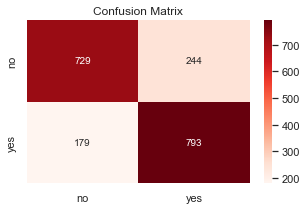

In [17]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state = 42)
lgr.fit(X_train,y_train)
print(f' Training -Set Accuracy score is {lgr.score(X_train, y_train)*100:.2f}%')
print(f' Testing - Set Accuracy score is {lgr.score(X_test, y_test)*100:.2f}%')
y_pred1 = lgr.predict(X_test)
cm = confusion_matrix(y_test, y_pred1)

print()
fig,ax = plt.subplots(figsize = (5,3))
sns.heatmap(pd.DataFrame(cm, columns =['no',"yes"], \
    index = ["no", "yes"]),cmap = 'Reds',xticklabels = True, annot =True,fmt = "d", ax = ax)
ax.set(title ="Confusion Matrix");

 Training -Set Accuracy score is 100.00%
 Testing - Set Accuracy score is 96.86%


              precision    recall  f1-score   support

          no       0.95      0.99      0.97       973
         yes       0.99      0.95      0.97       972

    accuracy                           0.97      1945
   macro avg       0.97      0.97      0.97      1945
weighted avg       0.97      0.97      0.97      1945



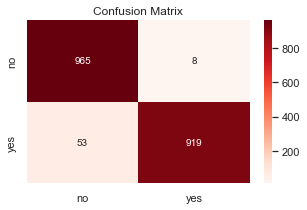

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators= 100, n_jobs = 1 , random_state = 42)
clf.fit(X_train,y_train)

print(f' Training -Set Accuracy score is {clf.score(X_train, y_train)*100:.2f}%')
print(f' Testing - Set Accuracy score is {clf.score(X_test, y_test)*100:.2f}%')

y_pred2 = clf.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred2)

print()
fig,ax = plt.subplots(figsize = (5,3))
sns.heatmap(pd.DataFrame(cm2, columns =['no',"yes"], \
    index = ["no", "yes"]),cmap = 'Reds',xticklabels = True, annot =True,fmt = "d", ax = ax)
ax.set(title ="Confusion Matrix");

print()
cr = classification_report(y_test, y_pred2)
print(cr)

## Save the model

In [19]:
import pickle
pickle.dump(clf, open("model.pkl", "wb"))

In [20]:
import joblib
joblib.dump("clf","model.joblib")

['model.joblib']

In [21]:
X.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

In [22]:
ex = X.iloc[5].to_frame().transpose()
ex

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked


In [23]:
lex = transformer.transform(ex)

In [24]:
lex.shape, X_train.shape, X_test.shape, 

((1, 21), (7777, 21), (1945, 21))

In [25]:
transformerd = make_column_transformer(
    (OneHotEncoder(handle_unknown ='ignore'),features),
    remainder='passthrough')


In [26]:
input = ['Male',45,0,1,"Yes",'Private',"Rural",134,34,"never smoked"]
check = pd.DataFrame(input).T

In [27]:
transformer.fit_transform(ex)

array([[1.0, 1.0, 1.0, 1.0, 1.0, 81.0, 0, 0, 186.21, 29.0]], dtype=object)